In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/autos.csv', encoding = 'ISO-8859-1')

In [3]:
#Retirada de features que provavelmente nao afetam o preco:
data.drop(['dateCrawled','monthOfRegistration','dateCreated','nrOfPictures','lastSeen'],
          axis = 1, inplace = True)

#Como ha muitos nomes diferentes aparecendo soh uma vez, tambem eh prudente deletar:
data.drop('name', axis = 1, inplace = True)

#Retirada de dados desbalanceados:
data.drop(['seller','offerType'], axis = 1, inplace = True)
data_original = data
# %% Retirada de valores inconsistentes
# De acordo com o artigo do medium: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba


In [4]:
from scipy import stats
pd.set_option('display.max_columns', None)

#Lista de features numericas para analisar outliers:
numft = ['price','yearOfRegistration','powerPS','kilometer','postalCode']

#Se puramente igualasse ele consideraria o mesmo objeto (foi o que deu aqui, sei lah)
data_zscore = data.copy()

In [5]:
# %% Criando dataframe que permite a retirada de outliers
for feat in numft:
    data_zscore[feat] = np.abs(stats.zscore(data_zscore[feat]))

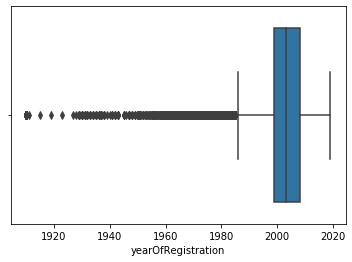

In [7]:
#Definindo threshold de 3 (3 desvios padroes):
threshold = 3
#Isso aqui vai me retornar as colunas e linhas com outliers:
iout = np.where(data_zscore[numft] > 3)

#Se eu quiser visualizar nos dados originais algum outlier a partir disso:
#Para ver o original precisaria fazer o standardscaler reverso
data.iloc[iout[0][500],iout[1][500]]

#No iout ele pode retornar duplicidade de linhas caso em uma mesma linha ocorra mais de um outlier
#Portanto este pequeno codigo se utiliza do bultin set para retornar as linhas unicas
irowsunique = list(set(list(iout[0])))

#Limpeza a partir dos indeces de linhas e colunas retornados
data_nooutlier = data.drop(data.index[irowsunique])

#Visualizacao em boxplot para verificar se realmente deletou outliers
sns.boxplot(data_nooutlier['yearOfRegistration'])


## Valores Faltantes

- Para visualizar se há valores faltantes em cada feature

In [8]:
np.sum(data_nooutlier.isnull())/data_nooutlier.shape[0]


price                 0.000000
abtest                0.000000
vehicleType           0.096871
yearOfRegistration    0.000000
gearbox               0.049342
powerPS               0.000000
model                 0.051710
kilometer             0.000000
fuelType              0.084682
brand                 0.000000
notRepairedDamage     0.187863
postalCode            0.000000
dtype: float64

- Para retornar apenas as linhas que não possuem valores faltantes

In [9]:
data_nomissing = data_nooutlier[data_nooutlier.isnull().any(axis = 1)==False]

- Não há mais valores faltantes

In [10]:
data_nomissing.isnull().sum().sum()

0

- Quantas linhas retiramos em relação ao anterior

In [11]:
data_nomissing.shape[0]/data_nooutlier.shape[0]

0.7098615693568017

- Em relação a base de dados original:

In [12]:
data_nomissing.shape[0]/data.shape[0]

0.6954953597037101

# Label Encoder

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
def label_encoder(data):
    """Funcao que permite transformar todas as features do tipo object"""
    
    label_encoder = LabelEncoder()
    
    #Retornar quais sao as features do tipo object que serao transformadas
    obj_features = list(data.select_dtypes(include = 'object'))
    obj_ft = [data.columns.get_loc(x) for x in obj_features]
    
    #Pode ser necessario transformar para string, mas na maioria dos casos nao
#     def obj2str(df, features):
#     for a in features:
#         df[a] = df[a].astype(str)
#     return df

#     data = obj2str(data, object_features_train)
    
    #Funcao que realizara efetivamente a transformacao
    def le(df, obj_ft):
        le = LabelEncoder()
        for ft in obj_ft:
            df[:,ft] = le.fit_transform(df[:,ft])
        return df

    data_le = pd.DataFrame(le(data.values, obj_ft), columns = data.columns).astype(float)
    
    return data_le

In [15]:
data_le = label_encoder(data_nomissing)

In [16]:
data_le

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,postalCode
0,1500.0,1.0,4.0,2001.0,1.0,75.0,118.0,150000.0,1.0,37.0,1.0,91074.0
1,3600.0,1.0,4.0,2008.0,1.0,69.0,103.0,90000.0,3.0,31.0,1.0,60437.0
2,650.0,1.0,6.0,1995.0,1.0,102.0,11.0,150000.0,1.0,2.0,0.0,33775.0
3,2200.0,1.0,2.0,2004.0,1.0,109.0,8.0,150000.0,1.0,25.0,1.0,67112.0
4,0.0,1.0,6.0,1980.0,1.0,50.0,40.0,40000.0,1.0,37.0,1.0,19348.0
...,...,...,...,...,...,...,...,...,...,...,...,...
258391,3200.0,0.0,6.0,2004.0,1.0,225.0,142.0,150000.0,1.0,30.0,0.0,96465.0
258392,1150.0,0.0,1.0,2000.0,1.0,0.0,249.0,150000.0,1.0,24.0,1.0,26624.0
258393,1199.0,1.0,2.0,2000.0,0.0,101.0,108.0,125000.0,1.0,32.0,1.0,26135.0
258394,9200.0,1.0,1.0,1996.0,1.0,102.0,224.0,150000.0,3.0,37.0,1.0,87439.0


# One Hot Encoder